In [78]:
import pandas as pd
import background
import os

def combine_excel_files(folder_path):
    dataframes = []
    first_df_columns = None
    
    # First pass: read first file to get column order
    for filename in os.listdir(folder_path):
        if filename.endswith('.xlsx'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_excel(file_path)
            df = background.structured_data(df)
            first_df_columns = df.columns.tolist()
            break
    
    if not first_df_columns:
        return pd.DataFrame()
    
    # Second pass: read all files and reorder columns
    for filename in os.listdir(folder_path):
        if filename.endswith('.xlsx'):
            file_path = os.path.join(folder_path, filename)
            
            # Read and process the file
            df = pd.read_excel(file_path)
            df = background.structured_data(df)
            
            # Add city column
            city_name = os.path.splitext(filename)[0]
            df['city'] = city_name
            
            # Ensure all columns exist
            for col in first_df_columns + ['city']:
                if col not in df.columns:
                    raise ValueError(f"Column {col} missing in file {filename}")
            
            # Reorder columns to match first DataFrame
            df = df[first_df_columns + ['city']]
            
            # Reset index
            df.reset_index(drop=True, inplace=True)
            
            dataframes.append(df)
    
    # Concatenate all DataFrames
    if dataframes:
        all_data = pd.concat(dataframes, ignore_index=True)
        return all_data
    else:
        return pd.DataFrame()

folder_path = 'dataset'
result = combine_excel_files(folder_path)
duplicate_columns = result.columns[result.columns.duplicated()].tolist()

if duplicate_columns:
    result = result.loc[:, ~result.columns.duplicated()]

In [79]:
unique_info = {}

for col in result.columns:
    unique_info[col] = {
        'unique_count': result[col].nunique(),
        'unique_values': result[col].unique().tolist()
    }
print("columns droped are")
for col, info in unique_info.items():
    if info['unique_count'] == 1:    
        print(f"Column: {col}")
        # print(f"Unique Count: {info['unique_count']}")
        # print(f"Unique Values: {info['unique_values']}")
        result.drop([col],axis=1,inplace=True)
        print()

columns droped are
Column: it

Column: trendingText.heading

Column: trendingText.desc



In [80]:
def check_missing_values(df, threshold_percentage=0.1):
    columns_to_drop = set()
        
    nan_counts = df.isnull().mean() 
    # print("NaN/None values in each column (%):\n", nan_counts * 100)
    
    columns_to_drop.update(nan_counts[nan_counts > threshold_percentage].index)
    
    empty_str_count = (df == '').mean() 
    # print("\nEmpty string values in each column (%):\n", empty_str_count * 100)
    
    columns_to_drop.update(empty_str_count[empty_str_count > threshold_percentage].index)
    
    space_only_count = (df.applymap(lambda x: isinstance(x, str) and x.isspace())).mean()
    # print("\nWhitespace-only values in each column (%):\n", space_only_count * 100)
    
    columns_to_drop.update(space_only_count[space_only_count > threshold_percentage].index)
    
    problematic_values = ['N/A', 'NA', 'null', 'NULL']
    for value in problematic_values:
        problematic_count = (df == value).mean()
        # print(f"\n'{value}' values in each column (%):\n", problematic_count * 100)
        
        columns_to_drop.update(problematic_count[problematic_count > threshold_percentage].index)
    
    df.drop(columns=columns_to_drop, inplace=True)
    print("\nColumns dropped:", columns_to_drop)
    return df
result = check_missing_values(result)


Columns dropped: {'wheel_size', 'misc_Drive Type', 'engine_Super Charger', 'engine_Fuel Suppy System', 'misc_Turning Radius', 'misc_Alloy Wheel Size', 'engine_Turbo Charger', 'misc_Acceleration', 'dimension_Front Tread', 'dimension_Rear Tread', 'dimension_Ground Clearance Unladen', 'engine_BoreX Stroke', 'engine_Compression Ratio', 'misc_Top Speed', 'engine_Value Configuration', 'rto', 'misc_Cargo Volumn', 'dimension_Gross Weight'}


In [81]:
result.drop(['oem','misc_Seating Capacity','ft','kms_driven','year_of_manufacture','ownership','owner','engine','engine_displacement','registration_year','engine_Max Power','engine_Max Torque'],axis=1,inplace=True)

In [82]:
def convert_price(price):
    # Remove the currency symbol and whitespace
    price = price.replace('₹', '').replace(',', '').strip()
    
    if 'Lakh' in price:
        # Handle 'Lakh'
        value = float(price.replace('Lakh', '').strip())
        return value * 100000  # Convert Lakh to number
    elif 'Crore' in price:
        # Handle 'Crore'
        value = float(price.replace('Crore', '').strip())
        return value * 10000000  # Convert Crore to number
    else:
        return float(price)

df = result['price'].apply(convert_price)
result.drop('price',axis=1,inplace=True)
result=pd.concat([result,df],axis=1)


In [83]:
result = result.dropna()
result['seats'] = result['seats'].str.extract('(\d+)').astype(int)
result['mileage'] = result['mileage'].str.replace(',', '').str.extract('(\d+\.\d+|\d+)').astype(float)
result['max_power'] = result['max_power'].str.replace(',', '').str.extract('(\d+\.\d+|\d+)').astype(float)
result['torque'] = result['torque'].str.replace(',', '').str.extract('(\d+\.\d+|\d+)').astype(float)
result['dimension_Length'] = result['dimension_Length'].str.extract('(\d+)').astype(int)
result['dimension_Width'] = result['dimension_Width'].str.extract('(\d+)').astype(int)
result['dimension_Height'] = result['dimension_Height'].str.extract('(\d+)').astype(int)
result['dimension_Wheel Base'] = result['dimension_Wheel Base'].str.extract('(\d+)').astype(int)
result['dimension_Kerb Weight'] = result['dimension_Kerb Weight'].str.extract('(\d+)').astype(int)

In [84]:
result['km'] = result['km'].str.replace(',', '').str.strip().astype(int)
result['engine_Displacement'] = result['engine_Displacement'].astype(int) 
result['misc_No Door Numbers'] = result['misc_No Door Numbers'].astype(int) 

In [85]:
result.to_csv('fulldata.csv',index=False)

In [86]:
df1=pd.read_csv('fulldata.csv')

In [87]:
numerical = df1.select_dtypes(include=['number'])
categorical = df1.select_dtypes(exclude=['number'])

In [88]:
from sklearn.preprocessing import LabelEncoder
import joblib

label_encoders = {}
df2 = categorical

for column in df2.columns:
    label_encoder = LabelEncoder()
    df2[column] = label_encoder.fit_transform(categorical[column])
    
    label_encoders[column] = label_encoder

joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [89]:
df=pd.DataFrame()
df=pd.concat([df2,numerical],axis=1)
df

,bt,transmission,model,variantName,insurance_validity,fuel_type,engine_Color,engine_Engine Type,misc_Gear Box,misc_Steering Type,...,engine_Displacement,engine_No of Cylinder,engine_Values per Cylinder,dimension_Length,dimension_Width,dimension_Height,dimension_Wheel Base,dimension_Kerb Weight,misc_No Door Numbers,price
0,2,1,135,1555,5,4,131,248,8,5,...,998,3.0,4.0,3715,1635,1565,2425,835,5,400000.0
1,7,1,44,273,2,4,131,341,7,5,...,1497,3.0,4.0,3998,1765,1647,2519,1242,4,811000.0
2,2,1,231,122,2,4,105,304,7,5,...,1199,3.0,4.0,3746,1647,1535,2400,1012,5,585000.0
3,8,1,77,94,2,4,82,275,8,5,...,1197,4.0,4.0,3995,1660,1520,2425,1180,4,462000.0
4,7,1,149,889,5,1,53,176,7,5,...,1248,4.0,4.0,4300,1785,1595,2600,1230,5,790000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,2,1,135,1766,5,4,82,251,14,1,...,998,3.0,4.0,3695,1655,1555,2435,810,5,510000.0
7495,2,1,130,1120,5,4,82,206,7,5,...,796,3.0,4.0,3395,1490,1475,2360,720,5,180000.0
7496,8,0,163,806,5,4,82,152,35,5,...,1796,4.0,4.0,4591,1770,1447,2760,1585,4,550000.0
7497,2,1,146,1781,5,4,82,244,7,5,...,1197,4.0,4.0,3775,1680,1620,2360,1030,5,140000.0


In [104]:
X = df.drop('price', axis=1)
correlation_matrix = X.corr()

threshold = 0.8
to_drop = set()
to_drop2 = []
to_drop1 = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            to_drop2.append(colname_j)
            to_drop1.append(colname_i)
            
            if colname_i not in to_drop and colname_j not in to_drop:
                to_drop.add(colname_i) 
                

X_reduced = X.drop(columns=to_drop)

print("Columns to drop:")
print(to_drop)
print(to_drop2)
print(to_drop1)

print("Remaining features after dropping highly correlated columns:")
print(X_reduced.columns)

Columns to drop:
{'engine_Displacement', 'dimension_Width', 'torque'}
['max_power', 'max_power', 'dimension_Length', 'torque', 'engine_Displacement']
['torque', 'engine_Displacement', 'dimension_Width', 'dimension_Kerb Weight', 'dimension_Kerb Weight']
Remaining features after dropping highly correlated columns:
Index(['bt', 'transmission', 'model', 'variantName', 'insurance_validity',
       'fuel_type', 'engine_Color', 'engine_Engine Type', 'misc_Gear Box',
       'misc_Steering Type', 'misc_Front Brake Type', 'misc_Rear Brake Type',
       'misc_Tyre Type', 'city', 'km', 'ownerNo', 'modelYear',
       'centralVariantId', 'seats', 'feature', 'mileage', 'max_power',
       'engine_No of Cylinder', 'engine_Values per Cylinder',
       'dimension_Length', 'dimension_Height', 'dimension_Wheel Base',
       'dimension_Kerb Weight', 'misc_No Door Numbers'],
      dtype='object')


<Axes: >

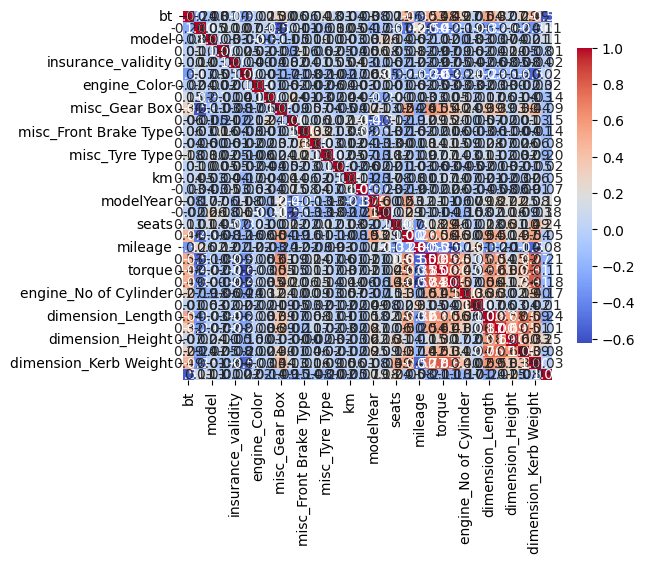

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the target variable from the feature set
X = df.drop('price', axis=1)

# # Calculate the correlation matrix
# correlation_matrix = X.corr()
# plt.figure(figsize=(10, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# # Add titles and labels
# plt.title('Correlation Matrix')
# plt.show()

In [92]:
print(correlation_matrix)

                                  bt  transmission     model  variantName  \
bt                          1.000000     -0.240101 -0.084171     0.010711   
transmission               -0.240101      1.000000  0.049565     0.099612   
model                      -0.084171      0.049565  1.000000    -0.030899   
variantName                 0.010711      0.099612 -0.030899     1.000000   
insurance_validity          0.003686      0.099292  0.034151    -0.020908   
fuel_type                  -0.313478      0.068599 -0.046296     0.048007   
engine_Color               -0.024193      0.036335 -0.001302     0.018836   
engine_Engine Type          0.149638      0.018183 -0.305740    -0.013692   
misc_Gear Box               0.302085     -0.585642 -0.105612    -0.026008   
misc_Steering Type          0.064464     -0.005267 -0.050362    -0.207577   
misc_Front Brake Type       0.060973      0.014863 -0.009792     0.164539   
misc_Rear Brake Type        0.038785     -0.059978  0.000360    -0.056702   